In [1]:

#cell1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")


Found 2880 audio files.

Audio DataFrame shape: (2880, 41)
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 'emotion']
            0          1          2          3         4         5          6  \
0 -563.286560  49.648838  -6.105738  10.458235 -5.491734 -0.331518  -9.950891   
1 -582.415039  53.827759  -6.217736   7.703194 -1.535678  4.751631 -11.035256   
2 -418.499878  39.591274 -25.592108  -2.834798 -5.696198 -2.106592 -18.492926   
3 -470.210693  48.589825  -8.505513   5.728758 -3.026507 -2.571906 -14.422111   
4 -650.492310  64.390381   0.829219  11.523897 -0.358622  3.591317  -6.460955   

          7          8         9  ...        31        32        33        34  \
0 -0.907412 -10.080370 -7.562868  ... -0.912676 -1.747537 -2.299448 -0.025205   
1 -6.731741 -12.881447 -9.406088  ...  3.619089  0.793563  0.743431  0.660723   
2 -7.546038 -12.406196 -9.510560  ...  0

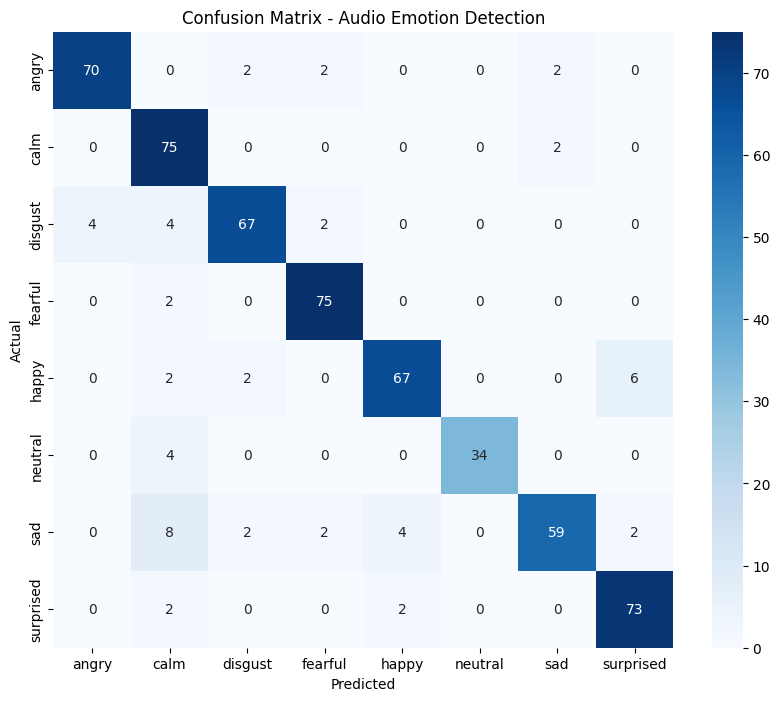

 Audio Model saved at: /Users/ananyasingh/Desktop/newdata11/audio/audio_emotion_model.pkl
 Scaler saved at: /Users/ananyasingh/Desktop/newdata11/audio/audio_scaler.pkl
🔹Label Encoder saved at: /Users/ananyasingh/Desktop/newdata11/audio/audio_label_encoder.pkl
Audio model, label encoder, and scaler saved successfully!


In [2]:

#cell 2
import glob
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#data loading 
audio_path = "/Users/ananyasingh/Desktop/newdata11/audio"
#finding all wav files
audio_files = glob.glob(os.path.join(audio_path, "**/*.wav"), recursive=True)
print(f"Found {len(audio_files)} audio files.")
#lists to store feature vectors and labels
audio_features = []
audio_labels = []
def extract_label_from_filename(filename):
#extracting emotion label from filename
    emotion_code = int(filename.split("-")[2]) 
    emotion_map = {
        1: "neutral", 2: "calm", 3: "happy", 4: "sad",
        5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"
    }
    return emotion_map.get(emotion_code, "unknown")
def extract_mfcc(file_path, n_mfcc=40):
    """
    Load an audio file, extract MFCC features,
    and return the mean of those features over time.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)  # Compute mean along time-axis
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
# Loop through each .wav file, extract MFCC features, and label by filename
for file in audio_files:
    feats = extract_mfcc(file)
    if feats is not None:
        audio_features.append(feats)
        label = extract_label_from_filename(os.path.basename(file))  # Extract label from filename
        audio_labels.append(label)
# DataFrame of audio features
audio_df = pd.DataFrame(audio_features)
audio_df['emotion'] = audio_labels
print("\nAudio DataFrame shape:", audio_df.shape)
print("Columns:", audio_df.columns.tolist())
print(audio_df.head())
#data prepreocessing
# Encode emotion labels
audio_le = LabelEncoder()
audio_df['emotion_enc'] = audio_le.fit_transform(audio_df['emotion'])
# Features (MFCCs) and target labels
X_audio = audio_df.drop(['emotion', 'emotion_enc'], axis=1).values  
y_audio = audio_df['emotion_enc'].values  
# Train-test split (80% training, 20% testing)
X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(
    X_audio, y_audio, test_size=0.2, random_state=42, stratify=y_audio  # Stratify ensures balanced splits
)
# Apply Feature Scaling AFTER splitting to avoid data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_audio)  # Fit only on train set
X_test_scaled = scaler.transform(X_test_audio)        # Transform test set

# Train a Random Forest classifier
audio_clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
audio_clf.fit(X_train_scaled, y_train_audio)
y_pred_audio = audio_clf.predict(X_test_scaled)
# Accuracy Score
acc_audio = accuracy_score(y_test_audio, y_pred_audio)
print("\n Audio Model Evaluation:")
print("Accuracy:", acc_audio)
# Classification Report
print("\n Classification Report:\n", 
      classification_report(y_test_audio, y_pred_audio, target_names=audio_le.classes_))
cm_audio = confusion_matrix(y_test_audio, y_pred_audio)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_audio, annot=True, fmt='d', cmap='Blues',
            xticklabels=audio_le.classes_,
            yticklabels=audio_le.classes_)
plt.title("Confusion Matrix - Audio Emotion Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
import joblib
# Define paths
audio_model_path = "/Users/ananyasingh/Desktop/newdata11/audio/audio_emotion_model.pkl"
scaler_path = "/Users/ananyasingh/Desktop/newdata11/audio/audio_scaler.pkl"
encoder_path = "/Users/ananyasingh/Desktop/newdata11/audio/audio_label_encoder.pkl"
# Save the trained model, scaler, and label encoder
joblib.dump(audio_clf, audio_model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(audio_le, encoder_path)
print(f" Audio Model saved at: {audio_model_path}")
print(f" Scaler saved at: {scaler_path}")
print(f"🔹Label Encoder saved at: {encoder_path}")
import joblib
import os
save_dir = "/Users/ananyasingh/Desktop/newdata11/audio"
os.makedirs(save_dir, exist_ok=True)
# Save the trained audio model
joblib.dump(audio_clf, os.path.join(save_dir, "audio_emotion_model.pkl"))
# Save the label encoder
joblib.dump(audio_le, os.path.join(save_dir, "audio_label_encoder.pkl"))
# Save the feature scaler
joblib.dump(scaler, os.path.join(save_dir, "audio_scaler.pkl"))

print("Audio model, label encoder, and scaler saved successfully!")



Files already extracted!
Found CSV file: /Users/ananyasingh/Desktop/newdata11/emotion/extracted/fer2013/fer2013.csv
Dataset shape: (35887, 3)
Columns: Index(['emotion', 'pixels', 'Usage'], dtype='object')
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
Image data shape: (35887, 48, 48)
Emotion labels shape: (35887,)


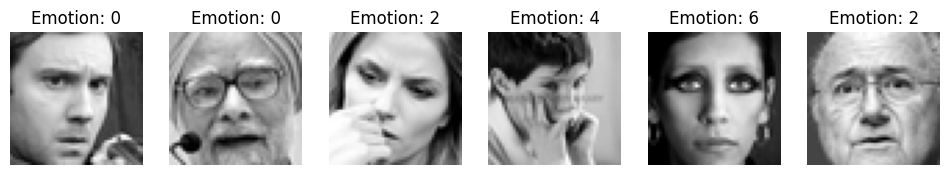

Training data shape: (28709, 2304)
Testing data shape: (7178, 2304)
Training Random Forest classifier...

Accuracy: 0.4687

Classification Report:
              precision    recall  f1-score   support

       Angry       0.54      0.20      0.29       991
     Disgust       1.00      0.25      0.40       109
        Fear       0.54      0.27      0.36      1024
       Happy       0.44      0.78      0.56      1798
         Sad       0.37      0.38      0.38      1216
    Surprise       0.66      0.62      0.64       800
     Neutral       0.46      0.40      0.43      1240

    accuracy                           0.47      7178
   macro avg       0.57      0.41      0.44      7178
weighted avg       0.49      0.47      0.45      7178



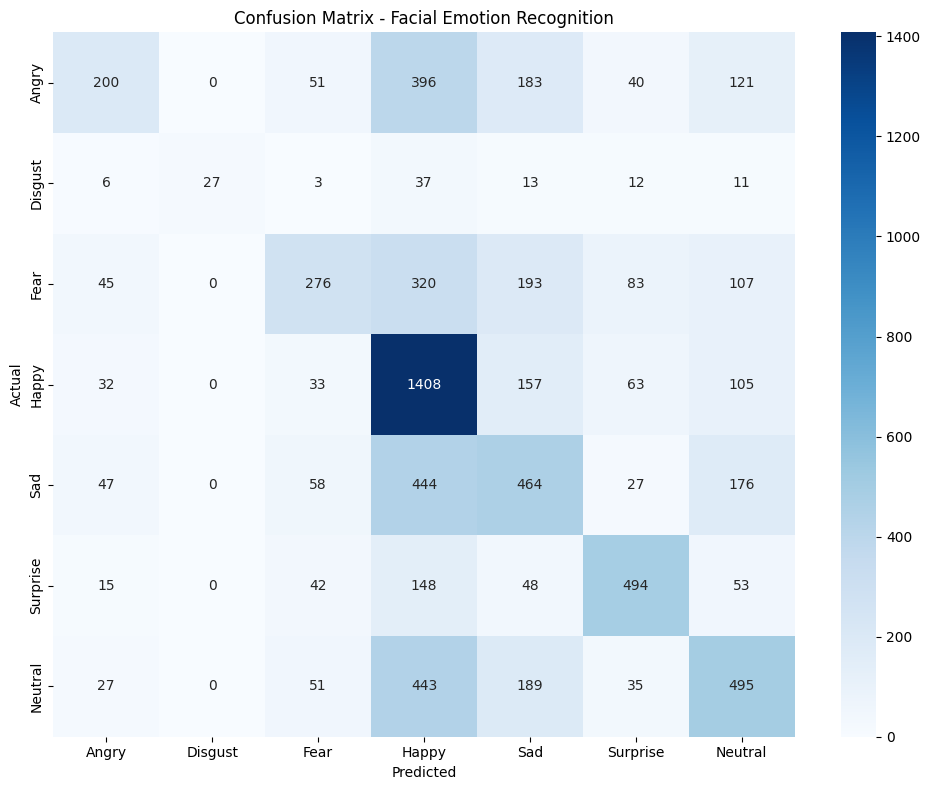

Model saved successfully at /Users/ananyasingh/Desktop/newdata11/emotion/emotion.pkl!
 Image Model saved at: /Users/ananyasingh/Desktop/newdata11/emotion/emotion_model.pkl
Face model and label encoder saved successfully!


In [3]:
#cell 3
import os
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Define paths
base_path = "/Users/ananyasingh/Desktop/newdata11/emotion"
tar_path = os.path.join(base_path, "fer2013.tar")
extract_dir = os.path.join(base_path, "extracted")  # Folder to extract files
# Extract tar file if not already extracted
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    if os.path.exists(tar_path):
        print("Extracting fer2013.tar...")
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(path=extract_dir)
        print("Extraction complete!")
    else:
        raise FileNotFoundError(f"Tar file not found at {tar_path}")
else:
    print("Files already extracted!")
# Locate CSV file after extraction
csv_file = None
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith(".csv"):
            csv_file = os.path.join(root, file)
            print(f"Found CSV file: {csv_file}")
            break

if not csv_file:
    raise FileNotFoundError("No CSV file found in the extracted directory!")

fer_data = pd.read_csv(csv_file)
print(f"Dataset shape: {fer_data.shape}")
print(f"Columns: {fer_data.columns}")
print(fer_data.head())

def preprocess_fer_data(data):
    # Extract emotion labels and pixel data
    emotions = data['emotion'].values  # Emotion labels (0-6)
    pixels = data['pixels'].apply(lambda x: np.array(x.split(), dtype=np.float32).reshape(48, 48))
    
    # Normalize pixel values (0-255 to 0-1)
    pixels = np.array([img / 255.0 for img in pixels])
    
    return pixels, emotions

X_img, y_img = preprocess_fer_data(fer_data)

print("Image data shape:", X_img.shape)
print("Emotion labels shape:", y_img.shape)

# Visualize a few sample images
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(X_img[i], cmap='gray')
    plt.title(f"Emotion: {y_img[i]}")
    plt.axis('off')
plt.show()

# Flatten images for Random Forest (convert 48x48 to 2304 features)
X_img_flattened = X_img.reshape(X_img.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(
    X_img_flattened, y_img, test_size=0.2, random_state=42, stratify=y_img
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print("Training Random Forest classifier...")
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # Use all CPU cores for faster computation
)

rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

emotion_labels = {
    0: "Angry", 1: "Disgust", 2: "Fear", 
    3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"
}

label_names = [emotion_labels.get(i) for i in sorted(np.unique(y_test))]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_names))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Confusion Matrix - Facial Emotion Recognition")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Save the trained model for future use
import joblib
model_path = os.path.join(base_path, "emotion.pkl")
joblib.dump(rf_clf, model_path)
print(f"Model saved successfully at {model_path}!")
# Save the trained image model
image_model_path = "/Users/ananyasingh/Desktop/newdata11/emotion/emotion_model.pkl"
joblib.dump(rf_clf, image_model_path)
print(f" Image Model saved at: {image_model_path}")
import joblib
import os

save_dir = "/Users/ananyasingh/Desktop/newdata11/emotion"
os.makedirs(save_dir, exist_ok=True)

# Save the trained face model
joblib.dump(rf_clf, os.path.join(save_dir, "emotion_model.pkl"))

# Save the label encoder (if needed)
face_le = LabelEncoder()
face_le.fit(y_img)  # Fit the encoder on emotion labels
joblib.dump(face_le, os.path.join(save_dir, "face_label_encoder.pkl"))

print("Face model and label encoder saved successfully!")

# To Load the model
# loaded_image_model = joblib.load(image_model_path)


In [10]:
import cv2
import numpy as np
import joblib
import librosa
import sounddevice as sd
import soundfile as sf
import os

# Load pretrained models and components
audio_model = joblib.load("/Users/ananyasingh/Desktop/newdata11/audio/audio_emotion_model.pkl")
audio_scaler = joblib.load("/Users/ananyasingh/Desktop/newdata11/audio/audio_scaler.pkl")
audio_le = joblib.load("/Users/ananyasingh/Desktop/newdata11/audio/audio_label_encoder.pkl")

face_model = joblib.load("/Users/ananyasingh/Desktop/newdata11/emotion/emotion_model.pkl")
face_le = joblib.load("/Users/ananyasingh/Desktop/newdata11/emotion/face_label_encoder.pkl")

# Emotion label mappings from training
FACE_EMOTION_MAP = {
    0: "Angry", 1: "Disgust", 2: "Fear",
    3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"
}

AUDIO_EMOTION_MAP = {
    1: "neutral", 2: "calm", 3: "happy", 
    4: "sad", 5: "angry", 6: "fearful", 
    7: "disgust", 8: "surprised"
}

# Initialize face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def predict_face_emotion(frame):
    """Predict emotion from facial features using trained model"""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    if len(faces) == 0:
        return "No Face Detected", None
    
    x,y,w,h = faces[0]
    face_roi = cv2.resize(gray[y:y+h, x:x+w], (48,48))
    face_data = (face_roi / 255.0).flatten().reshape(1, -1)
    
    pred = face_model.predict(face_data)[0]
    return FACE_EMOTION_MAP[pred], (x,y,w,h)

def predict_audio_emotion():
    """Predict emotion from 5-second audio recording"""
    fs = 44100  # Sample rate from training
    try:
        print("\nRecording audio for 5 seconds...")
        recording = sd.rec(int(5 * fs), samplerate=fs, channels=1)
        sd.wait()
        
        # Save temporary file
        temp_path = "/tmp/audio_temp.wav"
        sf.write(temp_path, recording, fs)
        
        # Extract features matching training parameters
        y, sr = librosa.load(temp_path, sr=fs)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, 
                                   n_mfcc=40,
                                   n_fft=2048,
                                   hop_length=512)
        features = np.mean(mfccs.T, axis=0).reshape(1, -1)
        features = audio_scaler.transform(features)
        
        pred = audio_model.predict(features)[0]
        return AUDIO_EMOTION_MAP[pred + 1]  # +1 matches filename codes
        
    except Exception as e:
        return f"Error: {str(e)}"
    finally:
        if os.path.exists(temp_path):
            os.remove(temp_path)

def main():
    print("\n" + "="*50)
    print(" REAL-TIME EMOTION DETECTION SYSTEM ".center(50))
    print("="*50)
    print("\nInstructions:")
    print("- Face the webcam directly")
    print("- Press 'A' to analyze audio (5-second recording)")
    print("- Press 'Q' to exit\n")
    input("Press ENTER to start detection...")
    
    cap = cv2.VideoCapture(0)
    audio_result = "Press 'A' for audio analysis"
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        # Face prediction
        face_emotion, coords = predict_face_emotion(frame)
        
        # Display results
        if coords:
            x,y,w,h = coords
            cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2)
            cv2.putText(frame, f"Face: {face_emotion}", (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        
        cv2.putText(frame, f"Audio: {audio_result}", (10,30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
        
        cv2.imshow("Real-Time Detection", frame)
        
        key = cv2.waitKey(1)
        if key in [ord('q'), ord('Q')]:
            break
        elif key in [ord('a'), ord('A')]:
            audio_result = predict_audio_emotion()
    
    cap.release()
    cv2.destroyAllWindows()
    print("\nSystem shutdown successfully!")

if __name__ == "__main__":
    main()



        REAL-TIME EMOTION DETECTION SYSTEM        

Instructions:
- Face the webcam directly
- Press 'A' to analyze audio (5-second recording)
- Press 'Q' to exit


Recording audio for 5 seconds...

Recording audio for 5 seconds...

System shutdown successfully!
